In [2]:
import pandas as pd
import numpy as np
import glob
import sys
import os

In [3]:
n = [25, 50, 75, 100]
pm = [0, 0.01, 0.03, 0.05]
pc = [0, 0.1, 0.3, 0.5]
trn = [2,3,4,5]

In [4]:

file_list = []

for N in n:
    for m in pm:
        for c in pc:
            for t in trn:
                for i in range(1,21):
                    file_list.append(f'n{N}_pm{m}_pc{c}_t{t}_itr{i}.csv')


#file_list = glob.glob(os.path.join(os.getcwd(), "*.csv"))
#file_list = [f.replace(os.getcwd()+'/', '') for f in file_list]
dfs = [pd.read_csv(f) for f in file_list]
df = pd.concat(dfs, ignore_index=True)

In [5]:
print(df.head(50))

    step                 fitness  \
0      0    0.012383741664729863   
1      0    0.015868218029444707   
2      0    0.012957497491787113   
3      0    0.012957497491787113   
4      0     0.02828486374834793   
5      0     0.22107474421499906   
6      0     0.02828486374834793   
7      0    0.015868218029444707   
8      0     0.22107474421499906   
9      0     0.33513976074415414   
10     0     0.02828486374834793   
11     0  1.9929132225402484e-05   
12     0     0.02828486374834793   
13     0   0.0011814929253461735   
14     0     0.42319928710854066   
15     0     0.01489420265195866   
16     0     0.22107474421499906   
17     0      0.4761855975654958   
18     0    0.015868218029444707   
19     0   0.0003986082106849183   
20     0      0.4761855975654958   
21     0     0.42319928710854066   
22     0   0.0011814929253461735   
23     0    0.012383741664729863   
24     0    0.015868218029444707   
25  step                 fitness   
26     1      0.476185597565

In [6]:
df_t_dirty = pd.read_csv("n25_pm0_pc0_t2_itr1.csv")
df_t = df_t_dirty[df_t_dirty['step'] != 'step']
df_t = df_t_dirty[df_t_dirty['fitness'] != 'fitness']
df_t = df_t_dirty[df_t_dirty['genome'] != 'genome']
df_t = df_t.apply(pd.to_numeric, errors='ignore')
df_t = df_t.reset_index(drop=True)


/tmp/ipykernel_1366184/150920010.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_t = df_t.apply(pd.to_numeric, errors='ignore')


In [7]:
from scipy.spatial.distance import pdist
def calc_diversity(genomes):
    matrix = np.stack(genomes['genome'].values)
    distances = pdist(matrix, metric='euclidean')
    if len(distances) == 0: return 0.0
    return np.mean(distances)

In [8]:
import ast
def get_stats_for_file(filename):
    df_t_dirty = pd.read_csv(filename)
    file_split = filename.split('_')

    n_val = int(file_split[0][file_split[0].find('n')+1 :])
    pm_val = float(file_split[1][file_split[1].find('m')+1 :])
    pc_val = float(file_split[2][file_split[2].find('c')+1 :])
    t_val = int(file_split[3][file_split[3].find('t')+1 :])
    itr_val = int(file_split[4][file_split[4].find('r')+1 : file_split[4].find('.')])

    
    df_t = df_t_dirty[df_t_dirty['step'] != 'step']
    df_t = df_t[df_t['fitness'] != 'fitness']
    df_t = df_t[df_t['genome'] != 'genome']
    df_t = df_t.apply(pd.to_numeric, errors='ignore')
    df_t = df_t.reset_index(drop=True)
    
    df_t['genome'] = df_t['genome'].apply(ast.literal_eval)
    df_t['genome'] = df_t['genome'].apply(lambda x: [int(i) for i in x])
    
    
    stats = df_t.groupby('step')['fitness'].agg(['mean', 'max'])
    stats = stats.rename(columns={'mean': 'Average Fitness', 'max': 'Best Fitness'})
   
    
    diversity = df_t.groupby('step').apply(calc_diversity)
    stats['Diversity Metric'] = diversity


    idx_of_max = df_t.groupby('step')['fitness'].idxmax()
    stats['Best Genome'] = df_t.loc[idx_of_max].set_index('step')['genome']

    ones = (df_t['fitness'] == 1).groupby(df_t['step']).sum()
    stats['Solution Count'] = ones
    stats['Solution Found'] = (stats['Solution Count'] != 0).astype(int)
    
    stats['Generation'] = stats.index
    stats['Iteration'] = itr_val
    stats['Tournament Size'] = t_val
    stats['P_c'] = pc_val
    stats['P_m'] = pm_val
    stats['N'] = n_val
    
    # --- 8. Final Output ---
    cols = ['N', 'P_m', 'P_c', 'Tournament Size', 'Iteration', 'Generation', 
            'Average Fitness', 'Best Fitness', 'Solution Found', 'Solution Count', 
            'Best Genome', 'Diversity Metric']
    
    # Safely select columns that exist
    stats = stats[[c for c in cols if c in stats.columns]]
    
    return stats
   
    

In [9]:

df_total = pd.DataFrame()

#x = get_stats_for_file('n100_pm0.01_pc0.1_t2_itr1.csv')
for f in file_list:
    df_total = pd.concat([df_total, get_stats_for_file(f)], ignore_index=True)
#print(x)
#x.to_csv('test.csv',index=False)


/tmp/ipykernel_1366184/287832049.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_t = df_t.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_1366184/287832049.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversity = df_t.groupby('step').apply(calc_diversity)
/tmp/ipykernel_1366184/287832049.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_t = df_t.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_1366184/287832049.py:27: FutureWarning: DataFram

In [10]:
df_total = df_total.reset_index(drop=True)
print(df_total)
df_total.to_csv("master.csv", index=False)

          N   P_m  P_c  Tournament Size  Iteration  Generation  \
0        25  0.00  0.0                2          1           0   
1        25  0.00  0.0                2          1           1   
2        25  0.00  0.0                2          1           2   
3        25  0.00  0.0                2          1           3   
4        25  0.00  0.0                2          1           4   
...     ...   ...  ...              ...        ...         ...   
153595  100  0.05  0.5                5         20          25   
153596  100  0.05  0.5                5         20          26   
153597  100  0.05  0.5                5         20          27   
153598  100  0.05  0.5                5         20          28   
153599  100  0.05  0.5                5         20          29   

        Average Fitness  Best Fitness  Solution Found  Solution Count  \
0              0.121684      0.476186               0               0   
1              0.218215      0.476186               0        

In [105]:
import matplotlib.pyplot as plt
pop_filter_df = df_total[((df_total['P_m'] == 0.01) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['Tournament Size'] == 2))]
print(pop_filter_df)


          N   P_m  P_c  Tournament Size  Iteration  Generation  \
14400    25  0.01  0.3                2          1           0   
14401    25  0.01  0.3                2          1           1   
14402    25  0.01  0.3                2          1           2   
14403    25  0.01  0.3                2          1           3   
14404    25  0.01  0.3                2          1           4   
...     ...   ...  ...              ...        ...         ...   
130195  100  0.01  0.3                2         20          25   
130196  100  0.01  0.3                2         20          26   
130197  100  0.01  0.3                2         20          27   
130198  100  0.01  0.3                2         20          28   
130199  100  0.01  0.3                2         20          29   

        Average Fitness  Best Fitness  Solution Found  Solution Count  \
14400          0.109093      0.664267               0               0   
14401          0.150245      0.664267               0        

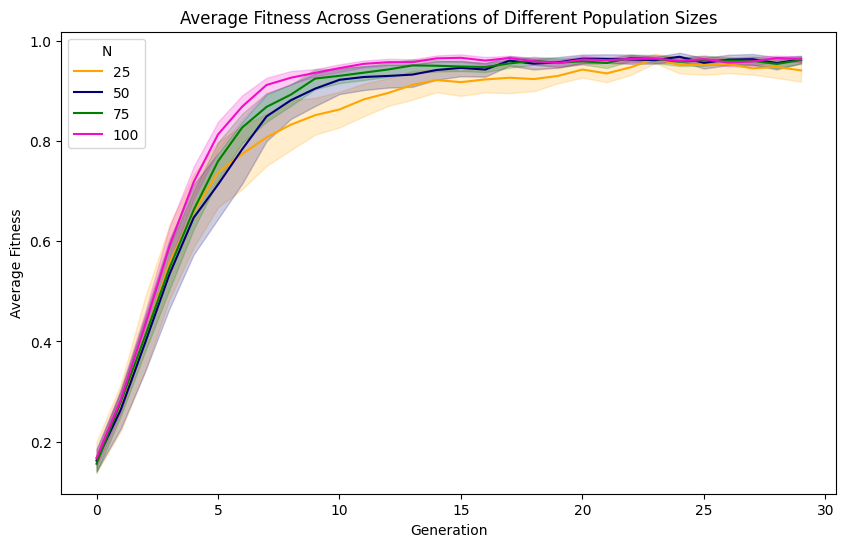

In [106]:

import seaborn as sns
import matplotlib.pyplot as plt
colors = ['orange', "#020074", 'green', '#f50cca']
plt.figure(figsize=(10, 6))
sns.lineplot(data=pop_filter_df, x='Generation', y='Average Fitness', hue='N', palette=colors).set(title='Average Fitness Across Generations of Different Population Sizes')
plt.show()



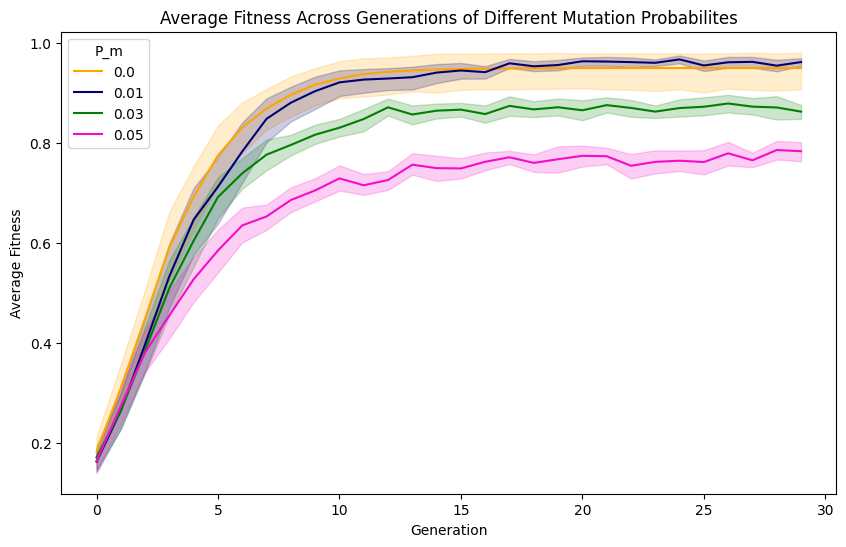

In [ ]:
pm_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
plt.ylim(0,1.05)

sns.lineplot(data=pm_filter_df, x='Generation', y='Average Fitness', hue='P_m', palette=colors).set(title='Average Fitness Across Generations of Different Mutation Probabilites')
plt.show()

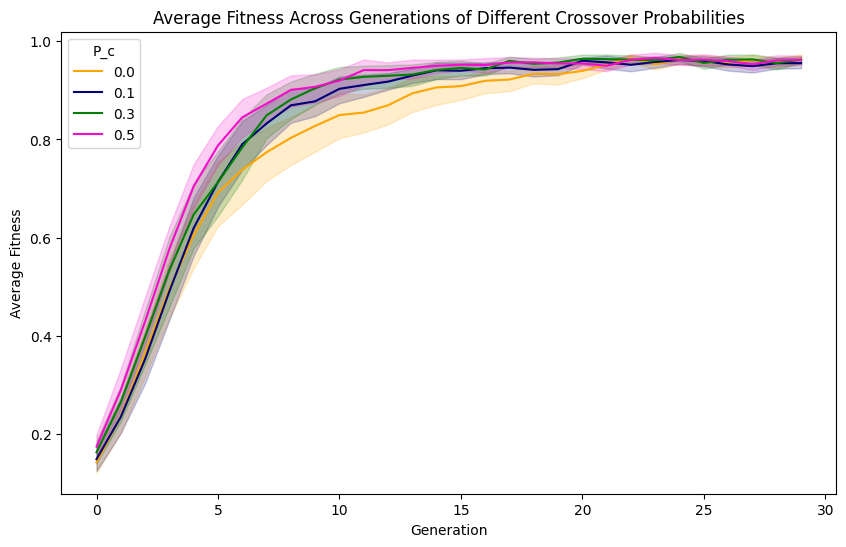

In [150]:
pc_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_m'] ==0.01) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=pc_filter_df, x='Generation', y='Average Fitness', hue='P_c', palette=colors).set(title='Average Fitness Across Generations of Different Crossover Probabilities')
plt.show()

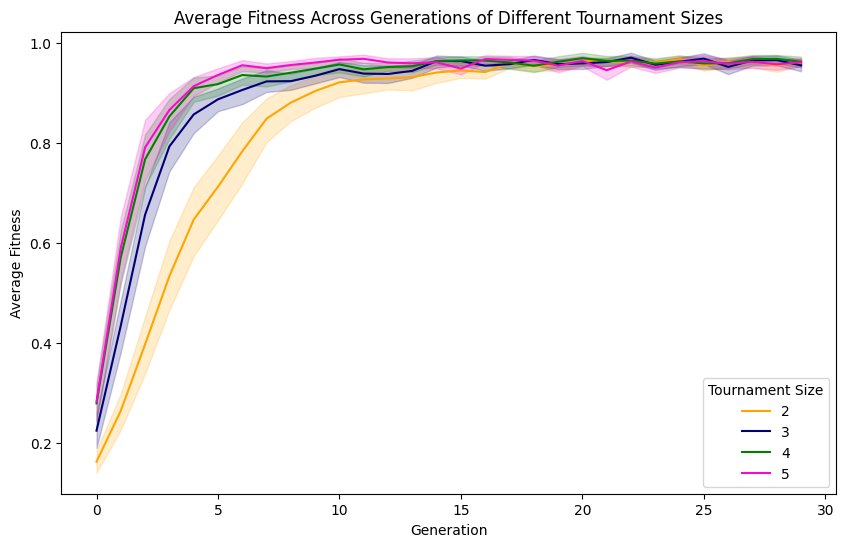

In [151]:
t_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['P_m'] == 0.01))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=t_filter_df, x='Generation', y='Average Fitness', hue='Tournament Size', palette=colors).set(title='Average Fitness Across Generations of Different Tournament Sizes')
plt.show()

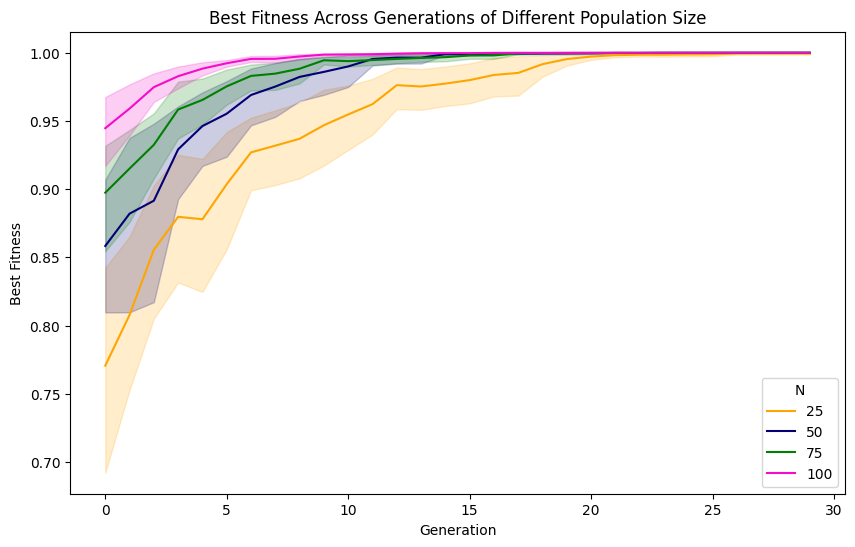

In [152]:


plt.figure(figsize=(10, 6))
sns.lineplot(data=pop_filter_df, x='Generation', y='Best Fitness', hue='N', palette=colors).set(title='Best Fitness Across Generations of Different Population Size')

plt.show()



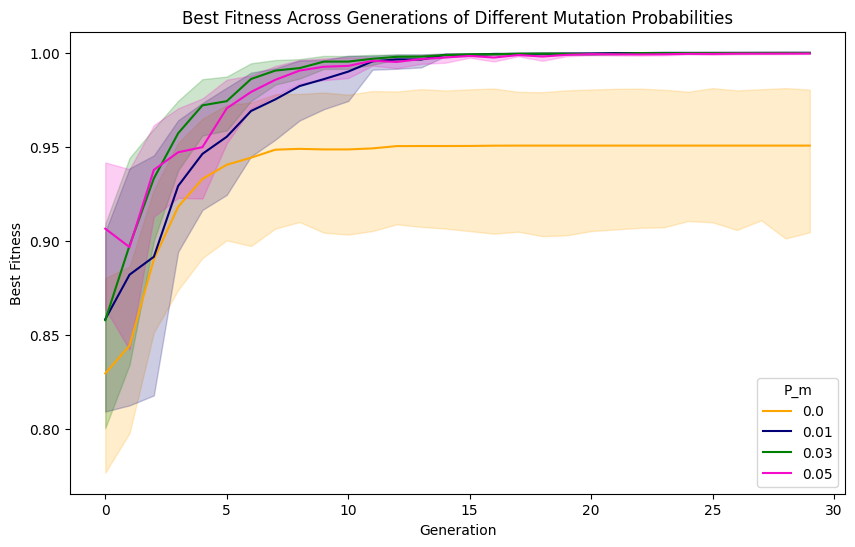

In [ ]:
#pm_filter_df = df_total[((df_total['N'] == 50) & 
#    (df_total['P_c'] ==0.3) & 
#    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=pm_filter_df, x='Generation', y='Best Fitness', hue='P_m', palette=colors).set(title='Best Fitness Across Generations of Different Mutation Probabilities')
plt.ylim(0,1.05)
plt.show()



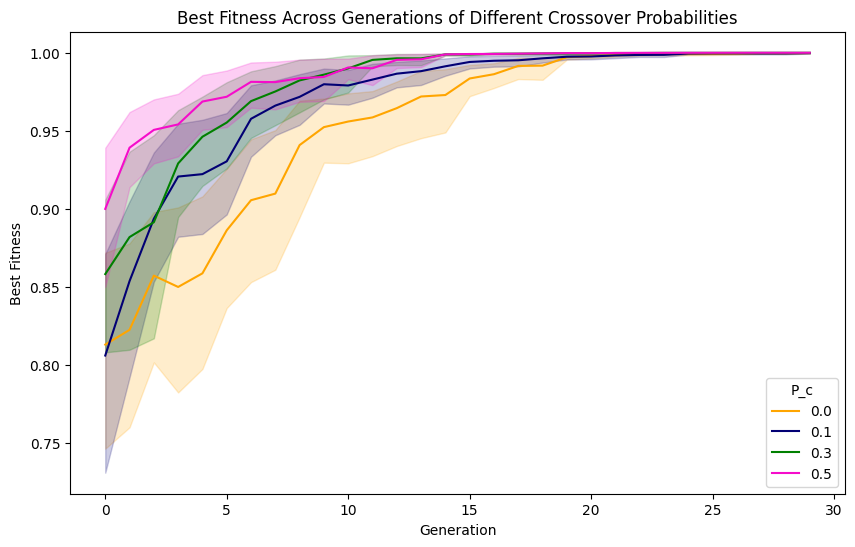

In [154]:
pc_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_m'] ==0.01) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=pc_filter_df, x='Generation', y='Best Fitness', hue='P_c', palette=colors).set(title='Best Fitness Across Generations of Different Crossover Probabilities')
plt.show()

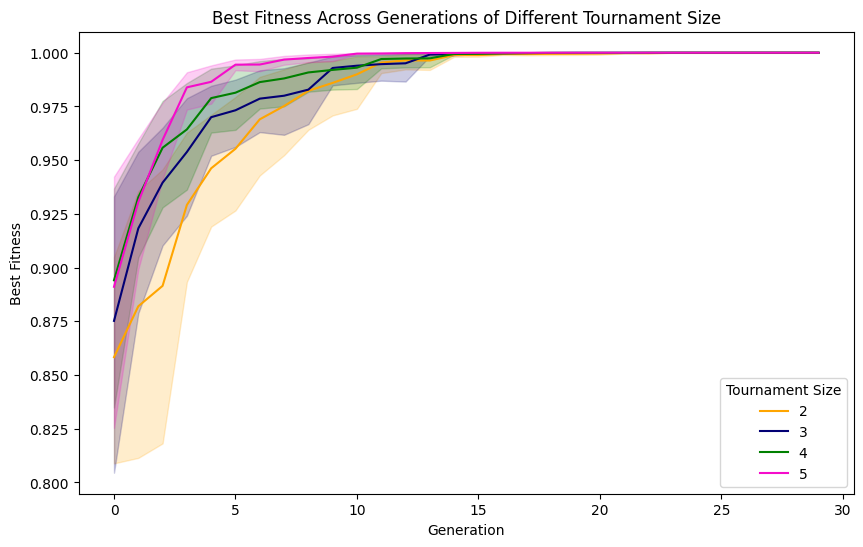

In [155]:
t_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['P_m'] == 0.01))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=t_filter_df, x='Generation', y='Best Fitness', hue='Tournament Size', palette=colors).set(title='Best Fitness Across Generations of Different Tournament Size')
plt.show()

In [156]:
successful_runs = df_total[df_total['Solution Found'] == 1]
unique_configs = successful_runs[['N', 'P_c', 'P_m', 'Tournament Size']].drop_duplicates()


results = []
for index, row in unique_configs.iterrows():
    mask = (
        (df_total['N'] == row['N']) & 
        (df_total['P_m'] == row['P_m']) & 
        (df_total['P_c'] == row['P_c']) & 
        (df_total['Tournament Size'] == row['Tournament Size'])
    )
    total_solutions_sum = df_total.loc[mask, 'Solution Count'].sum()
    results.append({
        'N': row['N'],
        'P_m': row['P_m'],
        'P_c': row['P_c'],
        'Tournament Size': row['Tournament Size'],
        'Total Solutions': total_solutions_sum
    })
unique_configs = pd.DataFrame(results)
unique_configs.to_csv('unique_ones.csv')

In [157]:
import math
from math import isnan
averages_for_n = {}
averages_for_pm = {}
averages_for_pc = {}
averages_for_t = {}
#print(f"Total individuals who found solution: {total_individuals}")
for N in n:
    total_individuals = df_total[df_total['N']==N]['Solution Count'].sum()
    averages_for_n[f'N={N}'] = total_individuals / 38400
for m in pm:
    total_individuals = df_total[df_total['P_m']==m]['Solution Count'].sum()
    averages_for_pm[f'P_m={m}'] = total_individuals / 38400
for c in pc:
    total_individuals = df_total[df_total['P_c']==c]['Solution Count'].sum()
    averages_for_pc[f'P_c={c}'] = total_individuals / 38400
for t in trn:
    total_individuals = df_total[df_total['Tournament Size']==t]['Solution Count'].sum()
    averages_for_t[f'T Size={t}'] = total_individuals / 38400


#averages_for_n = {k: 0 if (isinstance(v, float) and math.isnan(v)) else v for k, v in  averages_for_n.items()}
#averages_for_pm = {k: 0 if (isinstance(v, float) and math.isnan(v)) else v for k, v in  averages_for_pm.items()}
#averageaverages_for_pc = {k: 0 if (isinstance(v, float) and math.isnan(v)) else v for k, v in averages_for_pc.items()}
#averages_for_t = {k: 0 if (isinstance(v, float) and math.isnan(v)) else v for k, v in  averages_for_t.items()}



print(averages_for_n)
print(averages_for_pm)
print(averages_for_pc)
print(averages_for_t)


{'N=25': 0.0015364583333333333, 'N=50': 0.0022135416666666666, 'N=75': 0.004401041666666667, 'N=100': 0.005260416666666667}
{'P_m=0': 0.0, 'P_m=0.01': 0.009583333333333333, 'P_m=0.03': 0.0037760416666666667, 'P_m=0.05': 5.208333333333334e-05}
{'P_c=0': 7.8125e-05, 'P_c=0.1': 0.000625, 'P_c=0.3': 0.002994791666666667, 'P_c=0.5': 0.009713541666666667}
{'T Size=2': 0.0, 'T Size=3': 0.0003125, 'T Size=4': 0.005260416666666667, 'T Size=5': 0.007838541666666667}


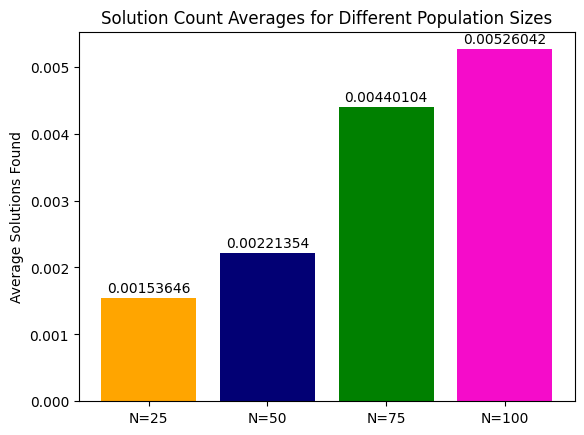

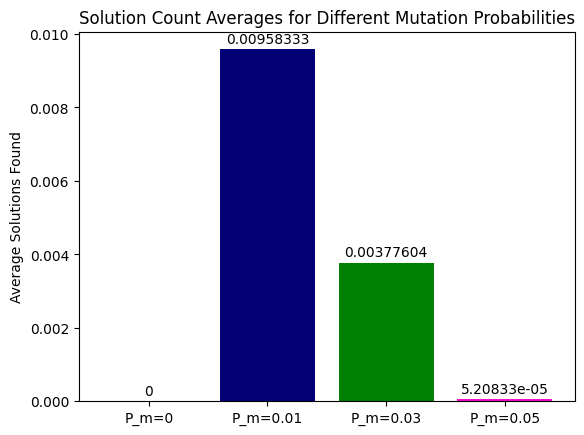

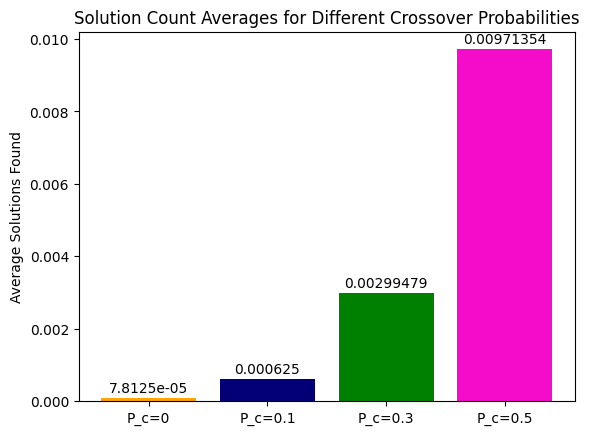

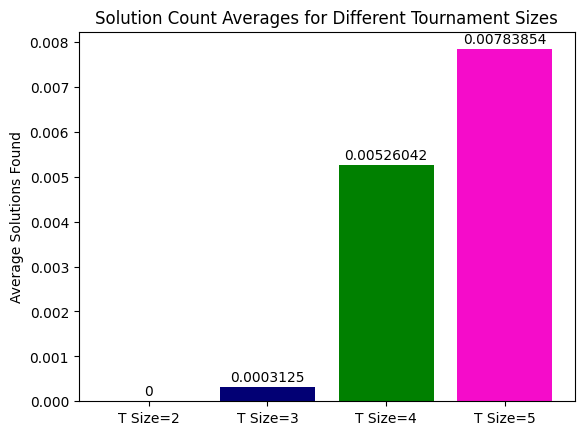

In [158]:
nbars = plt.bar(range(len(averages_for_n)), list(averages_for_n.values()), align='center', color=colors)
plt.title('Solution Count Averages for Different Population Sizes')
plt.ylabel('Average Solutions Found')
plt.bar_label(nbars, padding=2)
plt.xticks(range(len(averages_for_n)), list(averages_for_n.keys()))
plt.show()

pmbars = plt.bar(range(len(averages_for_pm)), list(averages_for_pm.values()), align='center', color=colors)
plt.title('Solution Count Averages for Different Mutation Probabilities')
plt.ylabel('Average Solutions Found')
plt.xticks(range(len(averages_for_pm)), list(averages_for_pm.keys()))
plt.bar_label(pmbars, padding=2)
plt.show()

pcbars = plt.bar(range(len(averages_for_pc)), list(averages_for_pc.values()), align='center', color=colors)
plt.title('Solution Count Averages for Different Crossover Probabilities')
plt.xticks(range(len(averages_for_pc)), list(averages_for_pc.keys()))
plt.ylabel('Average Solutions Found')
plt.bar_label(pcbars, padding=2)
plt.show()


tbars = plt.bar(range(len(averages_for_t)), list(averages_for_t.values()), align='center', color=colors)
plt.title('Solution Count Averages for Different Tournament Sizes')
plt.xticks(range(len(averages_for_t)), list(averages_for_t.keys()))
plt.ylabel('Average Solutions Found')
plt.bar_label(tbars, padding=2)
plt.show()


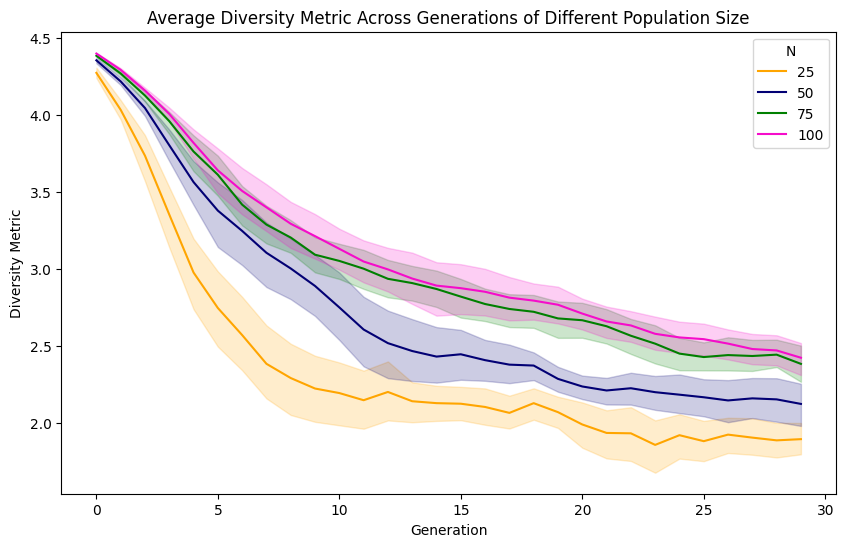

In [159]:
div_n_filter_df = df_total[((df_total['P_m'] == 0.01) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=div_n_filter_df, x='Generation', y='Diversity Metric', hue='N', palette=colors).set(title='Average Diversity Metric Across Generations of Different Population Size')
plt.show()

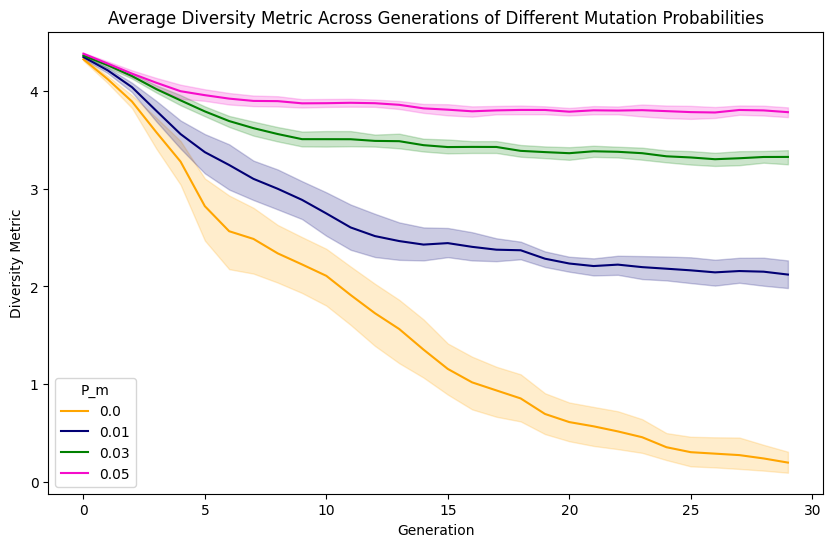

In [160]:
div_pm_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=div_pm_filter_df, x='Generation', y='Diversity Metric', hue='P_m', palette=colors).set(title='Average Diversity Metric Across Generations of Different Mutation Probabilities')
plt.show()

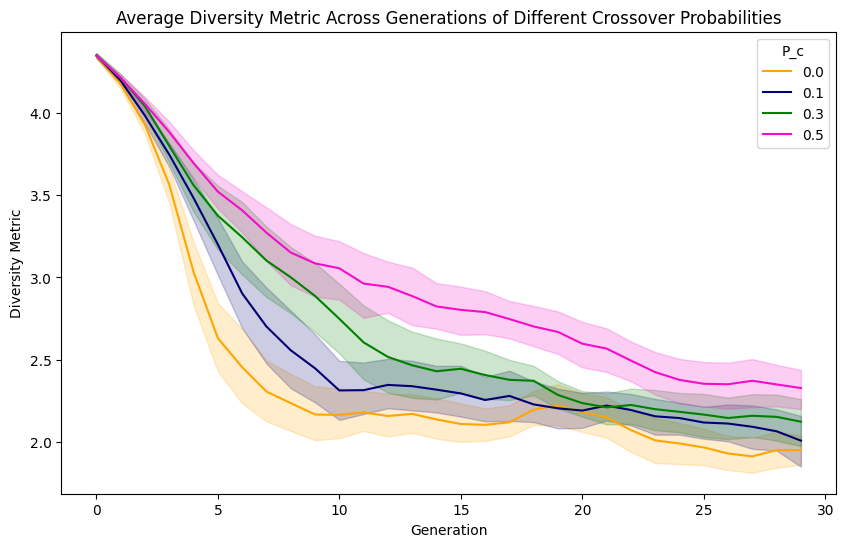

In [161]:
div_pc_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_m'] ==0.01) & 
    (df_total['Tournament Size'] == 2))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=div_pc_filter_df, x='Generation', y='Diversity Metric', hue='P_c', palette=colors).set(title='Average Diversity Metric Across Generations of Different Crossover Probabilities')
plt.show()

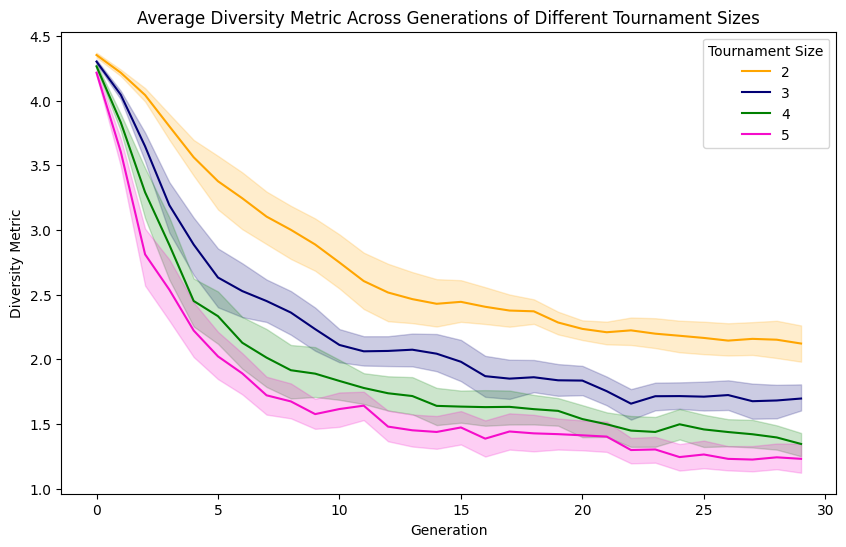

In [162]:
div_t_filter_df = df_total[((df_total['N'] == 50) & 
    (df_total['P_c'] ==0.3) & 
    (df_total['P_m'] == 0.01))]
plt.figure(figsize=(10, 6))
sns.lineplot(data=div_t_filter_df, x='Generation', y='Diversity Metric', hue='Tournament Size', palette=colors).set(title='Average Diversity Metric Across Generations of Different Tournament Sizes')
plt.show()

Observations:

* when P_c = 0 only 1 solution is found
* when P_m = 0 no solution is found
* when Tournament size = 2, no solution is found
* any size can find a solution but only 2 times for N=25, 

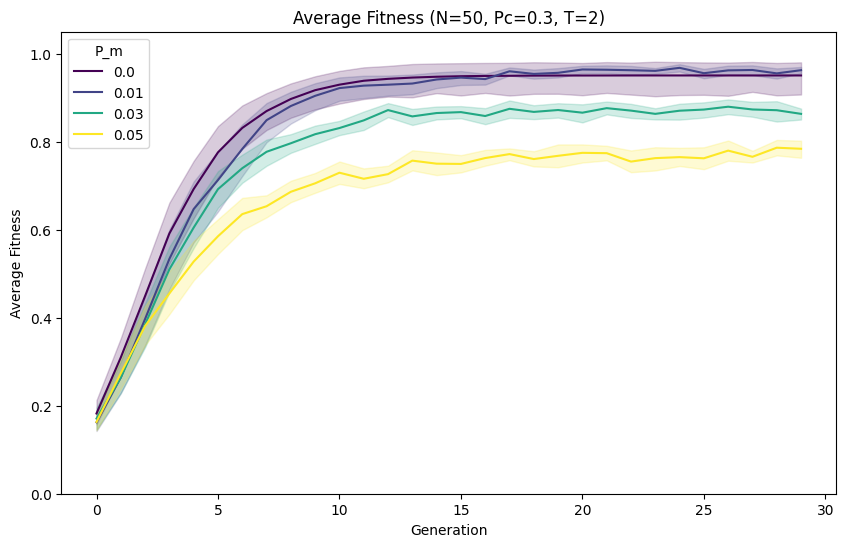

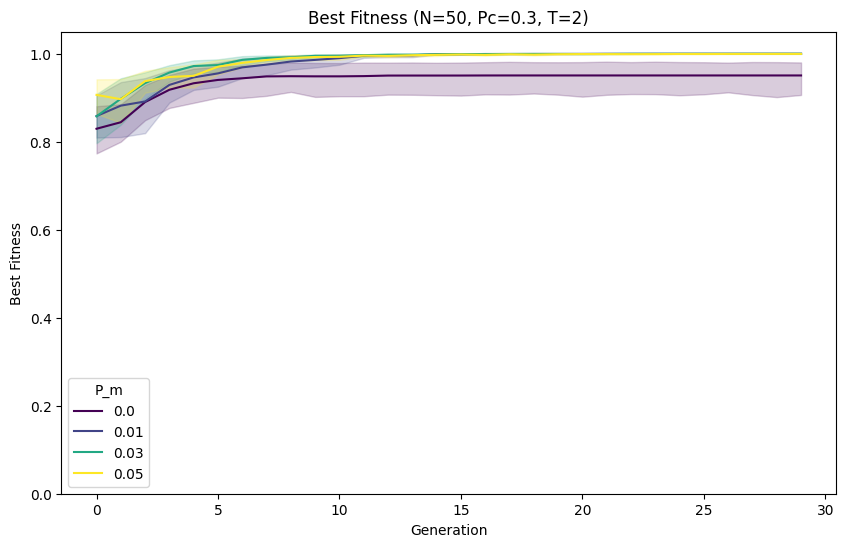

In [163]:
pm_filter_df = df_total[
    (df_total['N'] == 50) & 
    (df_total['P_c'] == 0.3) & 
    (df_total['Tournament Size'] == 2)
]

# 2. Plot Average Fitness
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=pm_filter_df, 
    x='Generation', 
    y='Average Fitness', 
    hue='P_m', 
    palette='viridis'
)
plt.title('Average Fitness (N=50, Pc=0.3, T=2)')
plt.ylim(0, 1.05)  # Set a fixed scale so you can compare easily
plt.show()

# 3. Plot Best Fitness (Using the SAME pm_filter_df)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=pm_filter_df, 
    x='Generation', 
    y='Best Fitness', 
    hue='P_m', 
    palette='viridis'
)
plt.title('Best Fitness (N=50, Pc=0.3, T=2)')
plt.ylim(0, 1.05)  # Set the same scale
plt.show()

Figure #'s
1. average pop
2. best pop
4. solutions bar pop
3. diversity pop

---

5. average Pm
6. best pm
8. solutions bar pm
7. diverse pm

---

9. average Pc
10. best pc
12. solutions bar pc
11. diverse pc

---

13. average tournament size
14. best tournament size
16. solutions bar tournament size
15. diverse tournament size